# AAVE (USD) — EDA and Price Prediction

This notebook performs Exploratory Data Analysis (EDA) and builds baseline machine learning and deep learning models to predict the next-day `close` price for `aave_usd_day.csv`.

All code cells include comments explaining the steps.

Import libraries and set plot style; optional xgboost/tensorflow imports.

In [1]:
# Imports and global settings (commented)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
# xgboost and tensorflow may need installation in your environment
try:
    from xgboost import XGBRegressor
except Exception:
    XGBRegressor = None
try:
    import tensorflow as tf
    from tensorflow import keras
except Exception:
    tf = None
# Plot style
sns.set(style="darkgrid")

C:\Users\Abdullah Khan\AppData\Roaming\Python\Python311\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Describe dataset path and intent to load close and timestamp.

**Load dataset** — we load `close` price and timestamp.

Dataset path: `./dataset/Top50PlusCryptoCurrenciesDailyMarketData/aave_usd_day.csv`.

Read CSV and show initial rows and dtypes for sanity check.

In [2]:
# Load CSV with parse_dates for the timestamp column (if available)
csv_path = './dataset/Top50PlusCryptoCurrenciesDailyMarketData/aave_usd_day.csv'
# Read the CSV safely
df = pd.read_csv(csv_path, parse_dates=True, infer_datetime_format=True)
# Quick look
print('Rows, cols:', df.shape)
display(df.head())
# Show column types
print(df.dtypes)

C:\Users\Abdullah Khan\AppData\Local\Temp\ipykernel_22648\2002240493.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(csv_path, parse_dates=True, infer_datetime_format=True)


FileNotFoundError: [Errno 2] No such file or directory: './dataset/Top50PlusCryptoCurrenciesDailyMarketData/aave_usd_day.csv'

Explain cleaning goals: ensure datetime index and numeric close.

**Basic cleaning** — ensure datetime index and numeric `close` column.

We will convert any timestamp-like column to `Date` index and coerce `close` to numeric.

Standardize datetime index and select/convert close column.

In [ ]:
# Make a copy and standardize columns we need
data = df.copy()
# Attempt to find a date column — common names: 'time', 'date', 'timestamp'
date_cols = [c for c in data.columns if 'date' in c.lower() or 'time' in c.lower() or 'timestamp' in c.lower()]
if len(date_cols) > 0:
    date_col = date_cols[0]
    data[date_col] = pd.to_datetime(data[date_col], errors='coerce')
    data = data.sort_values(by=date_col).set_index(date_col)
else:
    # If no obvious date column, try to interpret the first column as date
    try:
        data.iloc[:,0] = pd.to_datetime(data.iloc[:,0], errors='coerce')
        data = data.set_index(data.columns[0])
    except Exception:
        pass
# Ensure 'close' exists or pick a close-like column
close_cols = [c for c in data.columns if c.lower() in ('close','close_price','close_usd','price')]
if len(close_cols) == 0:
    # fallback: pick the last numeric column
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    close_col = numeric_cols[-1] if numeric_cols else None
else:
    close_col = close_cols[0]
print('Using close column:', close_col)
data['close'] = pd.to_numeric(data[close_col], errors='coerce')
# Drop rows without close or with missing index
data = data[~data['close'].isna()].copy()
data.index.name = 'date'
data = data.sort_index()
display(data[['close']].head())

Using close column: close


,close
date,
2026-01-10 00:00:00+00:00,270.750
2026-01-10 00:00:00+00:00,100.550
2026-01-10 00:00:00+00:00,104.160
2026-01-10 00:00:00+00:00,104.450
2026-01-10 00:00:00+00:00,99.312


In [ ]:
data


,date,open,high,low,close,volume,trade_count
date,,,,,,,
2026-01-10 00:00:00+00:00,2021-07-15,269.8300,284.0000,265.6700,270.750,1638.756800,708.0
2026-01-10 00:00:00+00:00,2024-07-16,104.0605,106.7635,99.3520,100.550,16.474587,4.0
2026-01-10 00:00:00+00:00,2024-07-15,104.5000,106.6500,101.4495,104.160,24.406891,11.0
2026-01-10 00:00:00+00:00,2024-07-14,99.2800,105.0500,99.1800,104.450,2.305009,2.0
2026-01-10 00:00:00+00:00,2024-07-13,97.5525,101.4690,95.6505,99.312,12.280000,2.0
...,...,...,...,...,...,...,...
2026-01-10 00:00:00+00:00,2023-01-07,56.3200,56.8100,55.7500,55.970,964.395228,150.0
2026-01-10 00:00:00+00:00,2023-01-06,55.4991,56.7300,54.1700,56.610,461.683715,197.0
2026-01-10 00:00:00+00:00,2023-01-05,56.8900,56.9100,54.9600,55.520,270.980842,119.0


Introduce price plot and moving averages (EDA section).

**EDA — price through time and moving averages**

Plot the `close` price and a few rolling means to visualise trend and smoothing effects.

Plot close price and rolling means (7, 30, 90).

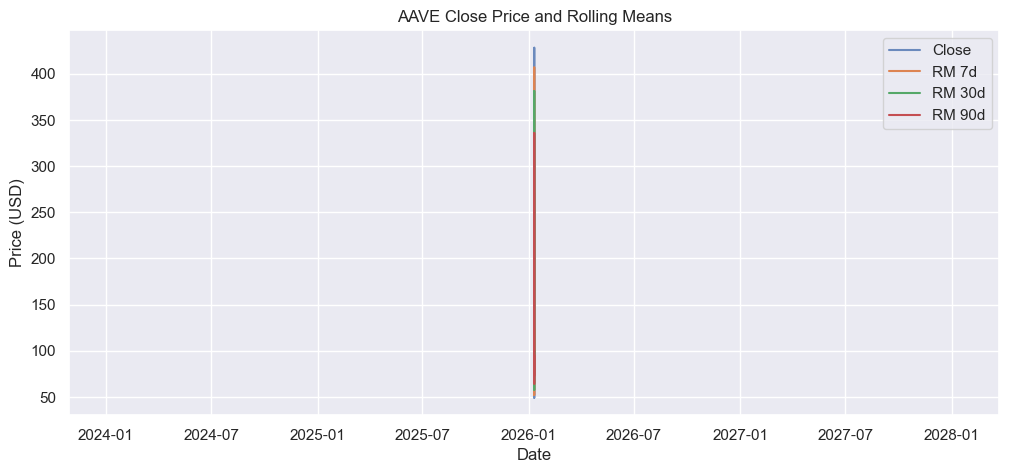

In [ ]:
# Plot close price and rolling means
plt.figure(figsize=(12,5))
plt.plot(data.index, data['close'], label='Close', alpha=0.8)
for w in (7, 30, 90):
    data[f'rm_{w}'] = data['close'].rolling(window=w).mean()
    plt.plot(data.index, data[f'rm_{w}'], label=f'RM {w}d')
plt.title('AAVE Close Price and Rolling Means')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Introduce returns and log-return distribution analysis.

**Returns and distribution** — compute log returns and visualise distribution.

Log returns are common for financial models and help stationarize the series.

Compute daily returns and log returns; plot histogram.

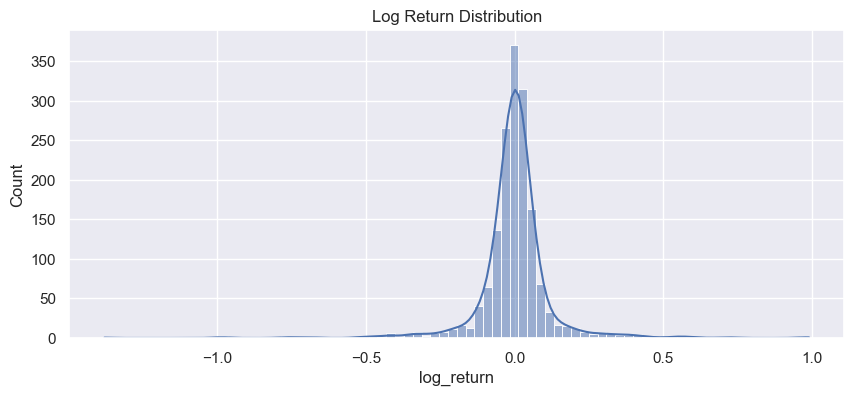

In [ ]:
# Calculate daily returns and log returns
data['return'] = data['close'].pct_change()
data['log_return'] = np.log(data['close']).diff()
plt.figure(figsize=(10,4))
sns.histplot(data['log_return'].dropna(), bins=80, kde=True)
plt.title('Log Return Distribution')
plt.show()

Introduce correlation heatmap for numeric features.

**Correlation** — if other numeric columns exist, inspect correlations with `close`.

Compute numeric correlations and plot heatmap.

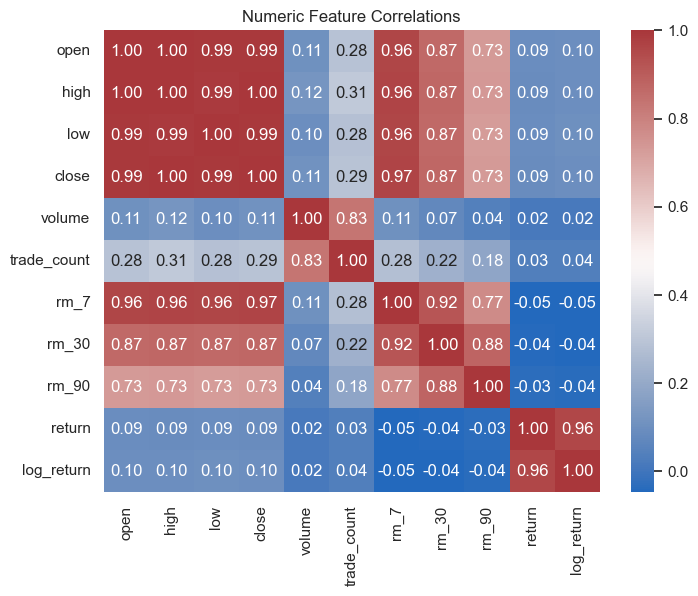

In [ ]:
# Show correlation heatmap for numeric features (including engineered ones)
numeric = data.select_dtypes(include=[np.number])
plt.figure(figsize=(8,6))
sns.heatmap(numeric.corr(), annot=True, fmt='.2f', cmap='vlag')
plt.title('Numeric Feature Correlations')
plt.show()

Introduce the advanced EDA section (decomposition, volatility, ACF/PACF, etc.).

**Advanced EDA**

This section performs time-series decomposition, volatility/range analysis, ACF/PACF, stationarity tests (ADF), lagged correlation heatmaps, log-return distribution analysis, and a simple candlestick-pattern mining summary.

Decompose series into trend/seasonal/residual where possible.

C:\Users\Abdullah Khan\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\seasonal.py:358: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\Abdullah Khan\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\seasonal.py:358: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\Abdullah Khan\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\seasonal.py:358: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)
C:\Users\Abdullah Khan\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\seasonal.py:358: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(xlim)


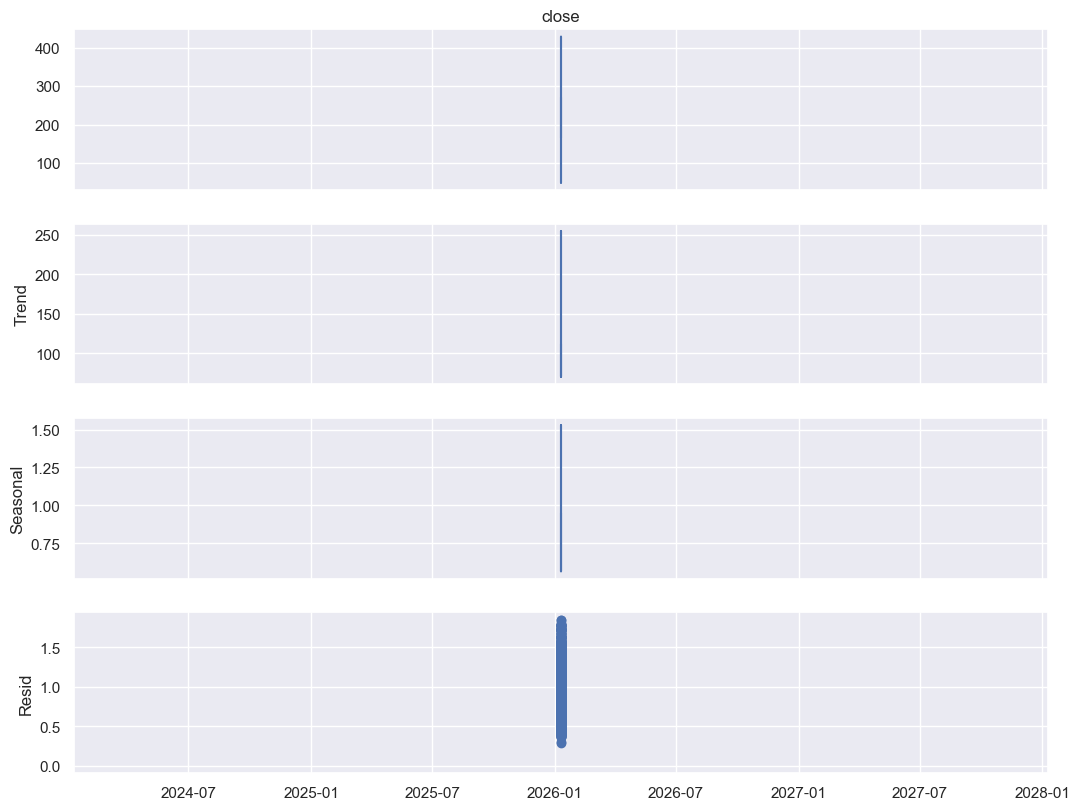

In [ ]:
# Time-series decomposition (seasonal_trend_resid)
try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    period = None
    if len(data) >= 365:
        period = 365
    elif len(data) >= 30:
        period = 30
    if period is not None and data['close'].dropna().shape[0] > period:
        decomp = seasonal_decompose(data['close'].dropna(), model='multiplicative' if (data['close']>0).all() else 'additive', period=period)
        fig = decomp.plot()
        fig.set_size_inches(12,9)
    else:
        print('Not enough data to run seasonal_decompose with an appropriate period; skipping decomposition.')
except Exception as e:
    print('statsmodels not available or decomposition failed:', e)

Compute high-low range, rolling means, and 30-day volatility.

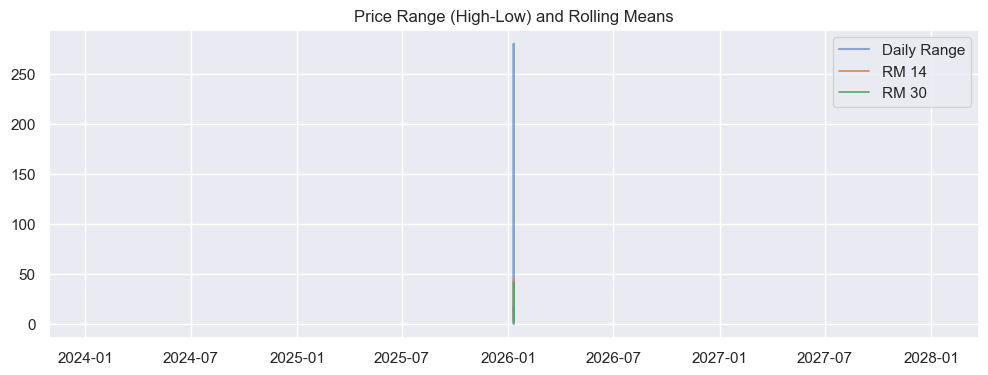

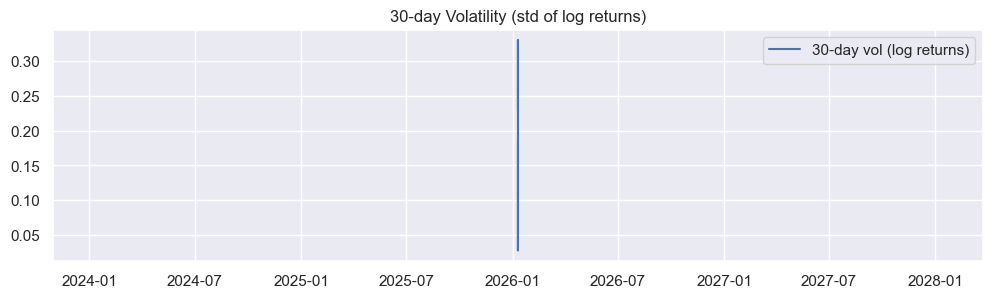

In [ ]:
# Volatility and range analysis: high-low spread and rolling stats
if set(['high','low']).issubset(data.columns.str.lower() if hasattr(data.columns, 'str') else data.columns):
    # handle mixed-case column names by matching lower-case
    cols_map = {c.lower(): c for c in data.columns}
    high_col, low_col = cols_map.get('high'), cols_map.get('low')
    data['range'] = data[high_col] - data[low_col]
else:
    # fallback: use rolling high-low on close as a proxy
    data['range'] = data['close'].rolling(window=2).apply(lambda x: x.max() - x.min(), raw=True)
data['range_rm_14'] = data['range'].rolling(14).mean()
data['range_rm_30'] = data['range'].rolling(30).mean()
plt.figure(figsize=(12,4))
plt.plot(data.index, data['range'], label='Daily Range', alpha=0.6)
plt.plot(data.index, data['range_rm_14'], label='RM 14', linewidth=1.2)
plt.plot(data.index, data['range_rm_30'], label='RM 30', linewidth=1.2)
plt.title('Price Range (High-Low) and Rolling Means')
plt.legend()
plt.show()
# Volatility by rolling std of log returns
data['log_return'] = np.log(data['close']).diff()
data['vol_30'] = data['log_return'].rolling(30).std()
plt.figure(figsize=(12,3))
plt.plot(data.index, data['vol_30'], label='30-day vol (log returns)')
plt.title('30-day Volatility (std of log returns)')
plt.legend()
plt.show()

Plot ACF and PACF for close (and volume if present) to assess serial correlation.

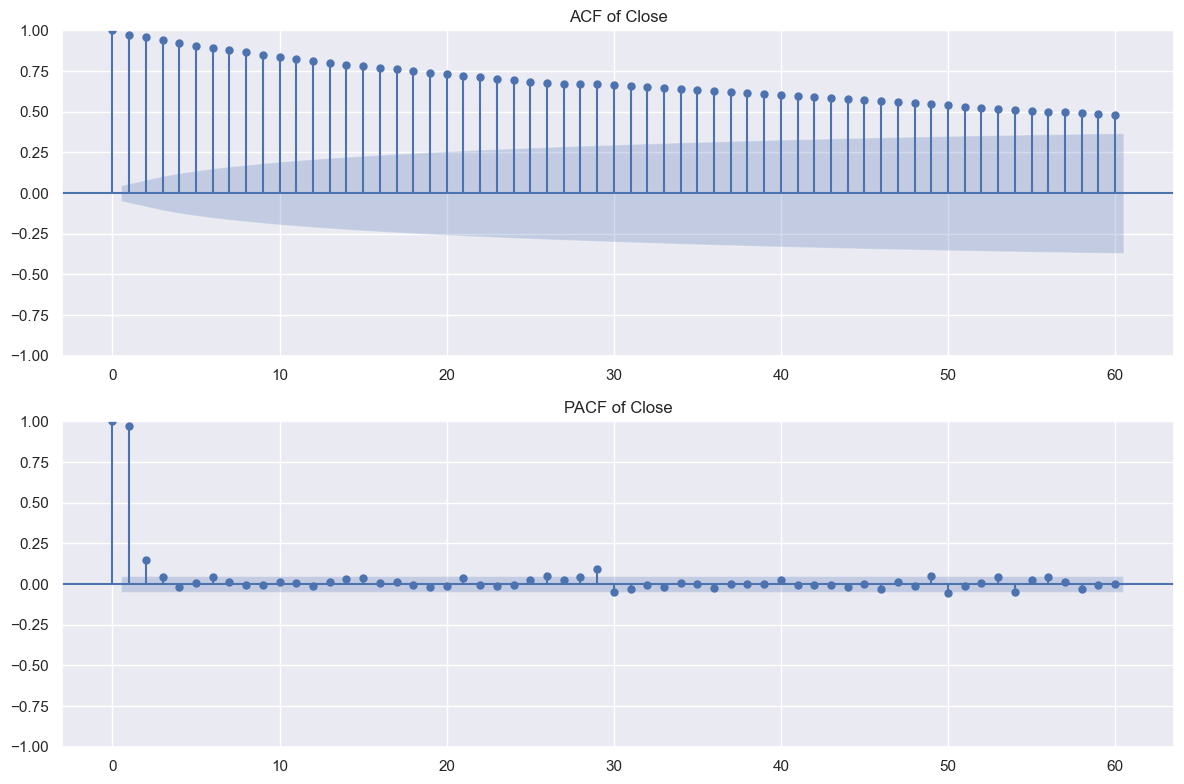

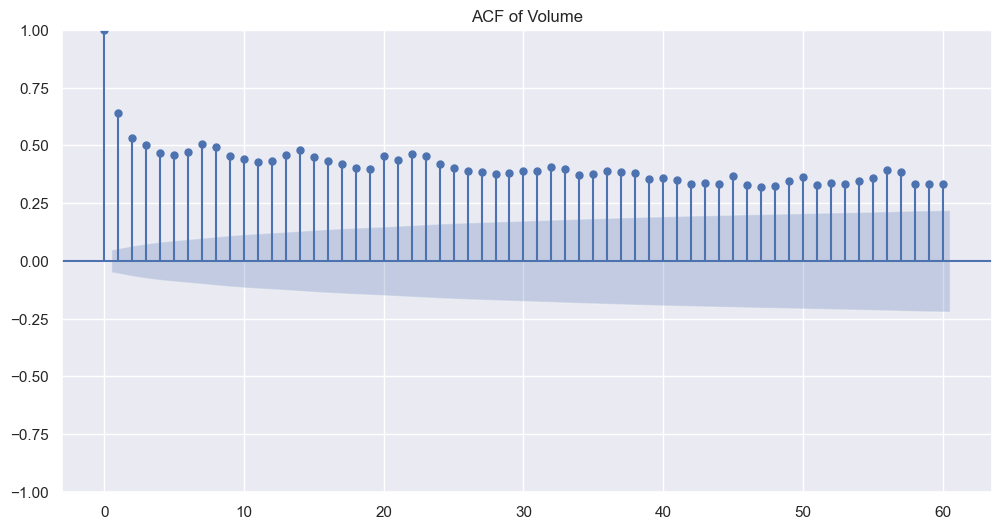

In [ ]:
# Autocorrelation and Partial Autocorrelation (ACF/PACF)
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    lags = min(60, int(len(data)/2)) if len(data) > 10 else 10
    plt.figure(figsize=(12,8))
    plt.subplot(2,1,1)
    plot_acf(data['close'].dropna(), lags=lags, ax=plt.gca(), title='ACF of Close')
    plt.subplot(2,1,2)
    plot_pacf(data['close'].dropna(), lags=lags, ax=plt.gca(), title='PACF of Close', method='ywm')
    plt.tight_layout()
    plt.show()
    if 'volume' in data.columns:
        plt.figure(figsize=(12,6))
        plot_acf(data['volume'].dropna(), lags=lags, ax=plt.gca(), title='ACF of Volume')
        plt.show()
except Exception as e:
    print('statsmodels tsaplots not available or failed:', e)

Run Augmented Dickey-Fuller test on close and log returns to check stationarity.

In [ ]:
# Augmented Dickey-Fuller (ADF) test for stationarity
try:
    from statsmodels.tsa.stattools import adfuller
    def run_adf(series, name='series'):
        series = series.dropna()
        if len(series) < 10:
            print(f'Not enough data for ADF on {name}')
            return
        res = adfuller(series)
        print(f'ADF on {name}: stat={res[0]:.4f}, p-val={res[1]:.4g}, usedlag={res[2]}, nobs={res[3]}')
        if res[1] < 0.05:
            print(' -> Reject null: series appears stationary at 5%')
        else:
            print(' -> Fail to reject null: series likely non-stationary')
    run_adf(data['close'], 'close')
    if 'log_return' not in data.columns:
        data['log_return'] = np.log(data['close']).diff()
    run_adf(data['log_return'].dropna(), 'log_return')
except Exception as e:
    print('statsmodels adfuller not available or failed:', e)

ADF on close: stat=-3.7726, p-val=0.0032, usedlag=2, nobs=1636
 -> Reject null: series appears stationary at 5%
ADF on log_return: stat=-32.9712, p-val=0, usedlag=1, nobs=1636
 -> Reject null: series appears stationary at 5%


Correlate lagged OHLCV features with next-day close and plot heatmap.

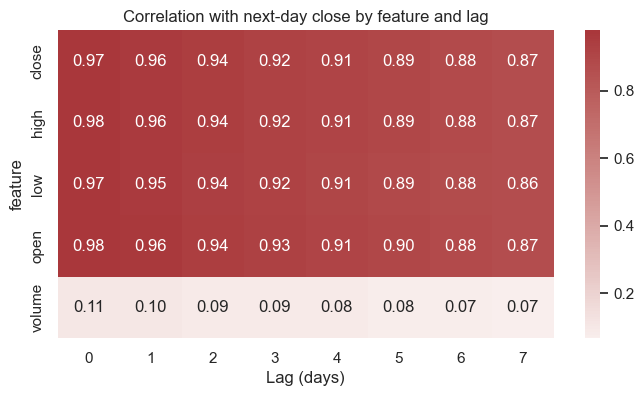

In [ ]:
# Correlation heatmap with time lags: how features at lag t relate to next-day close
features = [c for c in data.columns if c.lower() in ('open','high','low','close','volume')]
if len(features) == 0:
    print('No OHLCV-like features found for lagged correlation analysis.')
else:
    max_lag = 7
    target = data['close'].shift(-1)
    corr_df = pd.DataFrame(index=[f'{f}_lag{l}' for l in range(0, max_lag+1) for f in features], columns=['corr'])
    rows = []
    for f in features:
        for l in range(0, max_lag+1):
            s = data[f].shift(l)
            corr = s.corr(target)
            rows.append({'feature':f, 'lag':l, 'corr':corr})
    corr_tbl = pd.DataFrame(rows).pivot(index='feature', columns='lag', values='corr')
    plt.figure(figsize=(8,4))
    sns.heatmap(corr_tbl, annot=True, fmt='.2f', cmap='vlag', center=0)
    plt.title('Correlation with next-day close by feature and lag')
    plt.xlabel('Lag (days)')
    plt.show()

Plot log-return histogram, compute skew/kurtosis, and QQ-plot for normality checks.

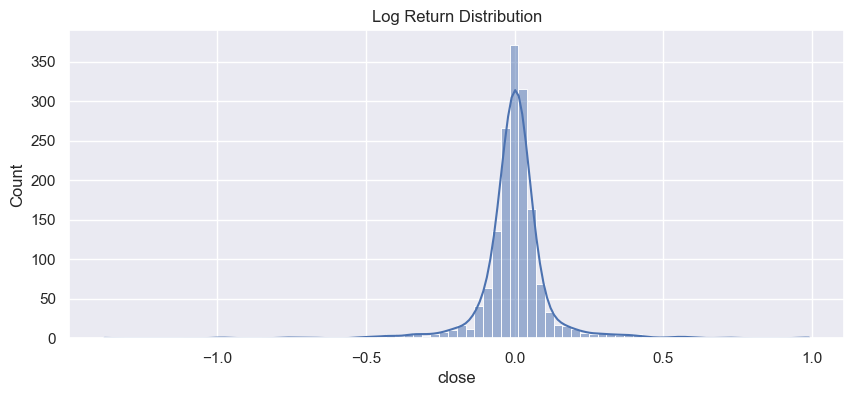

Skew: -0.8343237846611552 Kurtosis: 23.360024599858136


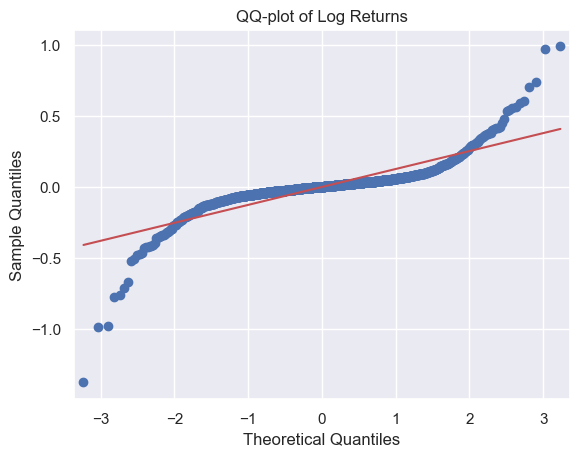

In [ ]:
# Distribution analysis of log returns: histogram, QQ-plot, skew/kurtosis
lr = np.log(data['close']).diff().dropna()
plt.figure(figsize=(10,4))
sns.histplot(lr, bins=80, kde=True)
plt.title('Log Return Distribution')
plt.show()
try:
    import scipy.stats as st
    print('Skew:', st.skew(lr.dropna()), 'Kurtosis:', st.kurtosis(lr.dropna()))
    import statsmodels.api as sm
    sm.qqplot(lr.dropna(), line='s')
    plt.title('QQ-plot of Log Returns')
    plt.show()
except Exception as e:
    print('scipy or statsmodels not available for distribution diagnostics:', e)

Mine simple, dataset-specific candlestick patterns and summarize next-day returns.

In [ ]:
# Simple candlestick pattern mining (dataset-specific) — bucketized body/size/direction
needed = set(['open','high','low','close'])
cols_lc = [c.lower() for c in data.columns]
if set(cols_lc).issuperset(needed):
    # map original column names
    cmap = {c.lower(): c for c in data.columns}
    o,h,l,c = cmap['open'], cmap['high'], cmap['low'], cmap['close']
    df_c = data[[o,h,l,c]].copy()
    df_c['body'] = df_c[c] - df_c[o]
    df_c['body_dir'] = df_c['body'].apply(lambda x: 'bull' if x>0 else ('bear' if x<0 else 'doji'))
    df_c['body_pct'] = (df_c['body'].abs() / (df_c[h] - df_c[l] + 1e-9)).fillna(0)
    df_c['size_q'] = pd.qcut(df_c['body_pct'].replace([np.inf, -np.inf], 0).fillna(0), q=4, labels=False, duplicates='drop')
    df_c['pattern'] = df_c['body_dir'].astype(str) + '_q' + df_c['size_q'].astype(str)
    df_c['next_ret'] = df_c[c].shift(-1) / df_c[c] - 1
    summary = df_c.groupby('pattern')['next_ret'].agg(['count','mean']).sort_values('count', ascending=False)
    display(summary.head(12))
    print('Top patterns by mean next-day return (min count 5):')
    display(summary[summary['count']>=5].sort_values('mean', ascending=False).head(10))
else:
    print('OHLC columns not found; skipping candlestick pattern mining.')

,count,mean
pattern,,
bear_q2,212,0.029376
bull_q3,212,-0.049130
bear_q1,211,0.018332
bear_q0,208,0.019068
bull_q0,200,-0.004059
bear_q3,198,0.076558
bull_q1,198,-0.003726
bull_q2,197,-0.023759
doji_q0,2,-0.001163


Top patterns by mean next-day return (min count 5):


,count,mean
pattern,,
bear_q3,198,0.076558
bear_q2,212,0.029376
bear_q0,208,0.019068
bear_q1,211,0.018332
bull_q1,198,-0.003726
bull_q0,200,-0.004059
bull_q2,197,-0.023759
bull_q3,212,-0.049130


Introduce feature-engineering step: lags, rolling stats, and target.

**Feature engineering** — create lag features, rolling stats and target.

We predict the next-day `close` price (regression).

Build lag features, rolling stats, and target for next-day close.

In [ ]:
# Create lag features and moving statistics
df_feat = data[['close']].copy()
# Lags and rolling windows
for lag in [1,2,3,7,14]:
    df_feat[f'lag_{lag}'] = df_feat['close'].shift(lag)
for w in [7,14,30]:
    df_feat[f'roll_mean_{w}'] = df_feat['close'].rolling(window=w).mean().shift(1)
    df_feat[f'roll_std_{w}'] = df_feat['close'].rolling(window=w).std().shift(1)
# Target: next-day close
df_feat['target'] = df_feat['close'].shift(-1)
df_feat = df_feat.dropna().copy()
display(df_feat.head())

,close,lag_1,lag_2,lag_3,lag_7,lag_14,roll_mean_7,roll_std_7,roll_mean_14,roll_std_14,roll_mean_30,roll_std_30,target
date,,,,,,,,,,,,,
2026-01-10 00:00:00+00:00,98.28500,101.55000,96.299,93.3299,98.5950,98.28500,97.258314,3.847865,96.579321,3.067330,99.212128,33.241395,103.75500
2026-01-10 00:00:00+00:00,103.75500,98.28500,101.550,96.2990,100.8550,97.28000,97.214029,3.831666,96.579321,3.067330,93.463295,7.494518,95.64000
2026-01-10 00:00:00+00:00,95.64000,103.75500,98.285,101.5500,98.9585,96.48795,97.628314,4.404850,97.041821,3.619556,93.570128,7.620801,97.11275
2026-01-10 00:00:00+00:00,97.11275,95.64000,103.755,98.2850,91.2208,93.51255,97.154243,4.416390,96.981254,3.636592,93.286128,7.367077,105.43600
2026-01-10 00:00:00+00:00,105.43600,97.11275,95.640,103.7550,93.3299,93.27550,97.995950,3.579192,97.238411,3.497053,93.041553,7.100649,110.29500


Describe time-based train/test split (earliest 80% training, latest 20% testing).

**Train/test split and scaling** — use the earliest 80% for training, latest 20% for testing (time-series split).

Split data by time and scale features using StandardScaler.

In [ ]:
# Time-based split
split_frac = 0.8
split_index = int(len(df_feat) * split_frac)
train = df_feat.iloc[:split_index].copy()
test = df_feat.iloc[split_index:].copy()
X_train = train.drop(columns=['target'])
y_train = train['target']
X_test = test.drop(columns=['target'])
y_test = test['target']
# Scale features for ML models
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)
print('Train/test sizes:', X_train.shape, X_test.shape)

Train/test sizes: (1286, 12) (322, 12)


Introduce Random Forest baseline for regression.

**Baseline: Random Forest** — train a RandomForestRegressor and report MAE/RMSE.

Train RandomForest, evaluate MAE/RMSE, and plot predictions.

RF MAE: 5.8472, RMSE: 9.7309


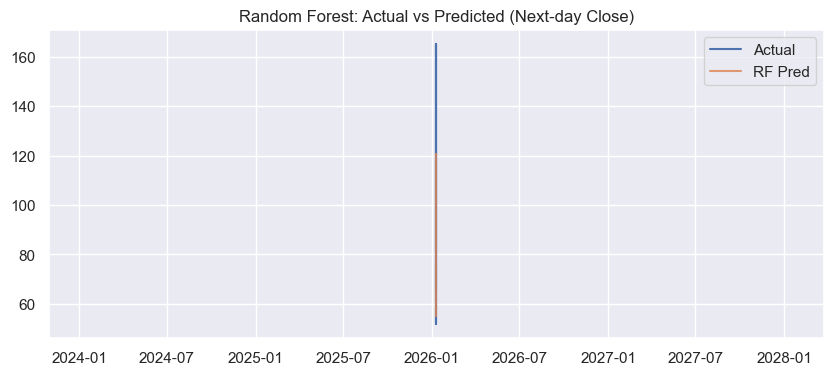

In [ ]:
# Train a Random Forest regressor as a baseline
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_s, y_train)
pred_rf = rf.predict(X_test_s)
mae_rf = mean_absolute_error(y_test, pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, pred_rf))
r2_rf = r2_score(y_test, pred_rf)
# Directional accuracy: did we predict the correct up/down movement vs previous close?
try:
    try:
        prev_close = X_test['close'].values
    except Exception:
        prev_close = X_test.iloc[:,0].values
    actual_dir = np.sign(y_test.values - prev_close)
    pred_dir = np.sign(pred_rf - prev_close)
    dir_acc_rf = float((actual_dir == pred_dir).mean())
except Exception:
    dir_acc_rf = None
print(f'RF MAE: {mae_rf:.4f}, RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}' + (f", DirAcc: {dir_acc_rf:.3%}" if dir_acc_rf is not None else 
# Plot predictions vs actual
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, pred_rf, label='RF Pred', alpha=0.8)
plt.legend()
plt.title('Random Forest: Actual vs Predicted (Next-day Close)')
plt.show()

Note XGBoost as optional stronger baseline.

**Optional: XGBoost** — use XGBoost if available for another strong baseline.

Train and evaluate XGBoost if available.

XGB MAE: 5.8875, RMSE: 11.6886


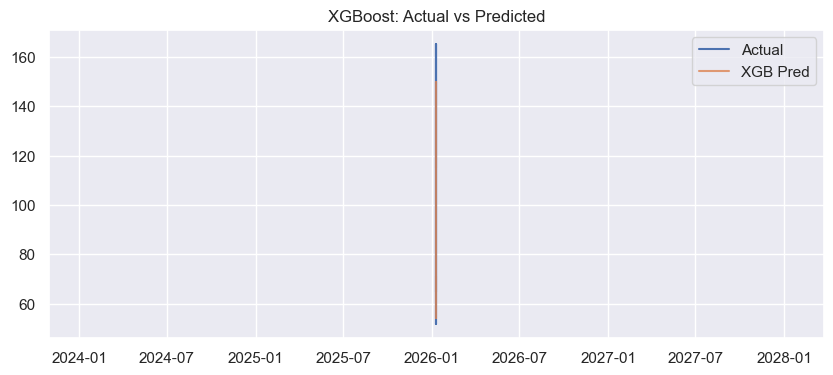

In [ ]:
# Train XGBoost if available
if XGBRegressor is not None:
    xgb = XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42, n_jobs=-1)
    xgb.fit(X_train_s, y_train)
    pred_xgb = xgb.predict(X_test_s)
    mae_xgb = mean_absolute_error(y_test, pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
    r2_xgb = r2_score(y_test, pred_xgb)
    try:
        try:
            prev_close = X_test['close'].values
        except Exception:
            prev_close = X_test.iloc[:,0].values
        actual_dir = np.sign(y_test.values - prev_close)
        pred_dir = np.sign(pred_xgb - prev_close)
        dir_acc_xgb = float((actual_dir == pred_dir).mean())
    except Exception:
        dir_acc_xgb = None
    print(f'XGB MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}' + (f", DirAcc: {dir_acc_xgb:.3%}" if dir_acc_xgb is not None else ", DirAcc: N/A"))
    plt.figure(figsize=(10,4))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, pred_xgb, label='XGB Pred', alpha=0.8)
    plt.legend()
    plt.title('XGBoost: Actual vs Predicted')
    plt.show()
else:
    print('XGBoost not available in the environment; skipping XGB training.')

Train XGBoost with scaled features and save the model to ./models if available.

XGB MAE: 6.0232, RMSE: 11.5688


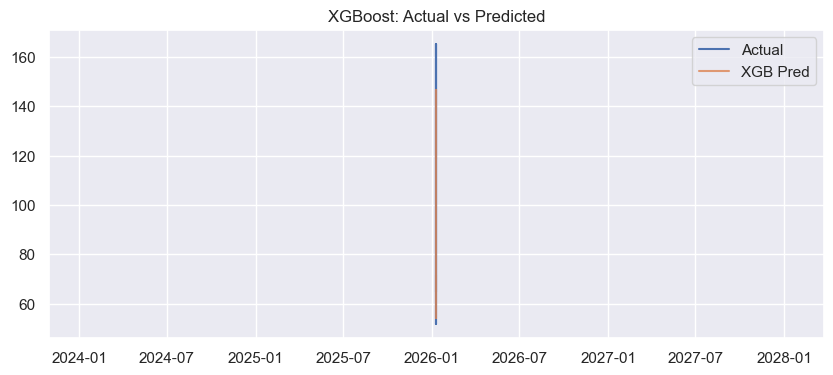

Saved XGBoost to ./models/xgb_aave.joblib


In [ ]:
# Train XGBoost (strong tree-based baseline) and persist the model
if XGBRegressor is None:
    print('XGBoost not installed; install xgboost to run this cell')
else:
    xgb = XGBRegressor(n_estimators=300, learning_rate=0.03, random_state=42, n_jobs=-1)
    xgb.fit(X_train_s, y_train)
    pred_xgb = xgb.predict(X_test_s)
    mae_xgb = mean_absolute_error(y_test, pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, pred_xgb))
    r2_xgb = r2_score(y_test, pred_xgb)
    try:
        try:
            prev_close = X_test['close'].values
        except Exception:
            prev_close = X_test.iloc[:,0].values
        actual_dir = np.sign(y_test.values - prev_close)
        pred_dir = np.sign(pred_xgb - prev_close)
        dir_acc_xgb = float((actual_dir == pred_dir).mean())
    except Exception:
        dir_acc_xgb = None
    print(f'XGB MAE: {mae_xgb:.4f}, RMSE: {rmse_xgb:.4f}, R2: {r2_xgb:.4f}' + (f", DirAcc: {dir_acc_xgb:.3%}" if dir_acc_xgb is not None else ", DirAcc: N/A"))
    plt.figure(figsize=(10,4))
    plt.plot(y_test.index, y_test.values, label='Actual')
    plt.plot(y_test.index, pred_xgb, label='XGB Pred', alpha=0.8)
    plt.legend()
    plt.title('XGBoost: Actual vs Predicted')
    plt.show()
    # persist
    os.makedirs('./models', exist_ok=True)
    joblib.dump(xgb, os.path.join('./models', 'xgb_aave.joblib'))
    print('Saved XGBoost to ./models/xgb_aave.joblib')

Train a small LSTM using the `close` series (sequence-to-one) and persist model + scaler.

Epoch 1/30
37/37 - 3s - 94ms/step - loss: 0.0581 - mae: 0.1658 - val_loss: 0.0156 - val_mae: 0.1019
Epoch 2/30
37/37 - 1s - 25ms/step - loss: 0.0090 - mae: 0.0654 - val_loss: 0.0126 - val_mae: 0.0657
Epoch 3/30
37/37 - 0s - 8ms/step - loss: 0.0076 - mae: 0.0585 - val_loss: 0.0103 - val_mae: 0.0597
Epoch 4/30
37/37 - 0s - 12ms/step - loss: 0.0071 - mae: 0.0556 - val_loss: 0.0083 - val_mae: 0.0464
Epoch 5/30
37/37 - 0s - 8ms/step - loss: 0.0062 - mae: 0.0512 - val_loss: 0.0089 - val_mae: 0.0521
Epoch 6/30
37/37 - 0s - 8ms/step - loss: 0.0055 - mae: 0.0489 - val_loss: 0.0066 - val_mae: 0.0392
Epoch 7/30
37/37 - 0s - 8ms/step - loss: 0.0057 - mae: 0.0507 - val_loss: 0.0078 - val_mae: 0.0453
Epoch 8/30
37/37 - 0s - 12ms/step - loss: 0.0054 - mae: 0.0477 - val_loss: 0.0082 - val_mae: 0.0455
Epoch 9/30
37/37 - 0s - 8ms/step - loss: 0.0050 - mae: 0.0463 - val_loss: 0.0059 - val_mae: 0.0359
Epoch 10/30
37/37 - 0s - 9ms/step - loss: 0.0047 - mae: 0.0430 - val_loss: 0.0059 - val_mae: 0.0365
Epoch

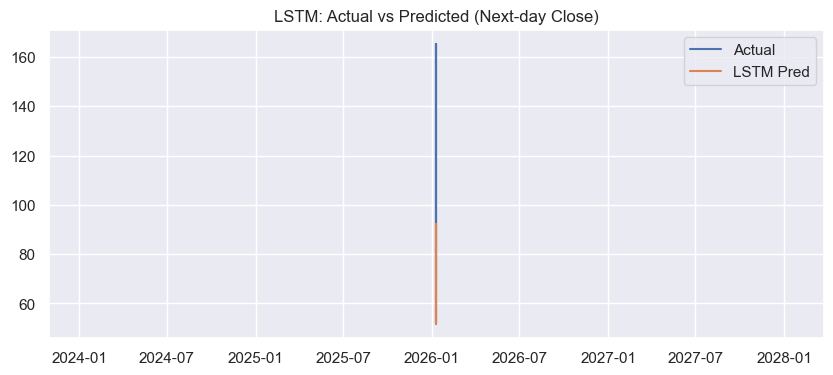

Saved LSTM and scaler to ./models


In [ ]:
# LSTM sequence-to-one using past `seq_len` closes to predict next close
try:
    if tf is None:
        print('TensorFlow not available; skipping LSTM training.')
    else:
        seq_len = 14
        arr = data['close'].values
        X_seq, y_seq = [], []
        for i in range(len(arr) - seq_len):
            X_seq.append(arr[i:i+seq_len])
            y_seq.append(arr[i+seq_len])
        X_seq = np.array(X_seq)
        y_seq = np.array(y_seq)
        # Train/test split (time-based)
        split_idx = int(len(X_seq) * 0.8)
        Xtr, Xte = X_seq[:split_idx], X_seq[split_idx:]
        ytr, yte = y_seq[:split_idx], y_seq[split_idx:]
        # Scale with MinMaxScaler fitted on training data
        scaler_lstm = MinMaxScaler()
        Xtr_flat = Xtr.reshape(-1,1)
        scaler_lstm.fit(Xtr_flat)
        Xtr_s = scaler_lstm.transform(Xtr_flat).reshape(Xtr.shape[0], seq_len, 1)
        Xte_s = scaler_lstm.transform(Xte.reshape(-1,1)).reshape(Xte.shape[0], seq_len, 1)
        ytr_s = scaler_lstm.transform(ytr.reshape(-1,1)).reshape(-1,1)
        yte_s = scaler_lstm.transform(yte.reshape(-1,1)).reshape(-1,1)
        # Build model
        model = keras.Sequential([
            keras.layers.Input(shape=(seq_len,1)),
            keras.layers.LSTM(64),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse', metrics=['mae'])
        history = model.fit(Xtr_s, ytr_s, validation_split=0.1, epochs=30, batch_size=32, verbose=2)
        # Predict and invert scale
        pred_s = model.predict(Xte_s).reshape(-1,1)
        pred = scaler_lstm.inverse_transform(pred_s).reshape(-1)
        yte_inv = scaler_lstm.inverse_transform(yte_s).reshape(-1)
        mae_lstm = mean_absolute_error(yte_inv, pred)
        rmse_lstm = np.sqrt(mean_squared_error(yte_inv, pred))
        try:
            r2_lstm = r2_score(yte_inv, pred)
        except Exception:
            r2_lstm = None
        try:
            prev_close = Xte[:, -1]
            actual_dir = np.sign(yte_inv - prev_close)
            pred_dir = np.sign(pred - prev_close)
            dir_acc_lstm = float((actual_dir == pred_dir).mean())
        except Exception:
            dir_acc_lstm = None
        print(f'LSTM MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}' + (f", DirAcc: {dir_acc_lstm:.3%}" if dir_acc_lstm is not None else ", DirAcc: N/A"))
        plt.figure(figsize=(10,4))
        idx_start = seq_len + split_idx
        dates = data.index[idx_start: idx_start + len(pred)]
        plt.plot(dates, yte_inv, label='Actual')
        plt.plot(dates, pred, label='LSTM Pred')
        plt.legend()
        plt.title('LSTM: Actual vs Predicted (Next-day Close)')
        plt.show()
        # persist model and scaler
        os.makedirs('./models', exist_ok=True)
        model.save(os.path.join('./models', 'lstm_aave.h5'))
        joblib.dump(scaler_lstm, os.path.join('./models', 'scaler_lstm_aave.joblib'))
        print('Saved LSTM and scaler to ./models')
except Exception as e:
    print('LSTM training failed:', e)

**Deep Learning: LSTM** — prepare sequences using `close` and some features, then train a simple LSTM network.

This is more data-hungry; we keep the architecture small to avoid overfitting on limited samples.

Mention saving models and scalers for later use.

**Save models and scalers** — persist trained models for later use.

We save RandomForest and scalers; XGBoost and LSTM saved conditionally if trained.

Persist trained models and scalers to ./models.

In [ ]:
out_dir = './models'
os.makedirs(out_dir, exist_ok=True)
joblib.dump(rf, os.path.join(out_dir, 'rf_aave.joblib'))
joblib.dump(scaler, os.path.join(out_dir, 'scaler_aave.joblib'))
if XGBRegressor is not None:
    joblib.dump(xgb, os.path.join(out_dir, 'xgb_aave.joblib'))
print('Saved models to', out_dir)

Saved models to ./models


Summarize conclusions and recommended next steps.

**Conclusion & next steps**

- RandomForest and XGBoost provide quick, interpretable baselines.
- LSTM can capture temporal dependencies but needs more data and careful tuning.
- Next: hyperparameter search, feature expansion (volume, external signals), and walk-forward validation.